In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
from load import WatermarkDataset
from yolo import YOLOv3Watermark, yolo_to_bbox_list, yolo_bbox_loss

In [2]:
# Initialize dataset
data_dir = 'logos_rendered'
dataset = WatermarkDataset(data_dir, WatermarkDataset.YOLO_MODE, format_bb=True)

# Split dataset into train and test
ratio = 0.8
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Set up the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(
    f'len dataset: {len(dataset)}, len train loader: {len(train_dataloader)}, '
    f'len test loader: {len(test_dataloader)}'
)

len dataset: 9788, len train loader: 62, len test loader: 16


In [4]:
model = YOLOv3Watermark()
criterion = yolo_bbox_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f'Device: {device}, {torch.cuda.get_device_name()}')

Device: cuda, NVIDIA GeForce RTX 4090


In [6]:
num_epochs = 150
model_path = f'yolov3watermark_{num_epochs}epochs.pt'
loaded_model_from_file = False
if os.path.exists(model_path):
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    loaded_model_from_file = True
    print(f'Loaded model from path: {model_path}')

else:
    print('Beginning training loop')
    model.to(device)
    model.train()
    train_loss = []

    # training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0

        for batch_idx, (images, targets) in enumerate(train_dataloader):
            # images shape: (batch_size, 3 (because of 3 rgb channels), 256, 256)
            # outputs and targets are torch.Size([batch_size, 4, 8, 8]
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)

            # print(f'targets: {targets.shape}, images: {images.shape}, outputs: {outputs.shape}')
            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_loss.append(epoch_loss)
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

Beginning training loop


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch [1/150], Loss: 2224094.0080566406
Epoch [11/150], Loss: 659845.2745361328
Epoch [21/150], Loss: 258834.90258789062
Epoch [31/150], Loss: 101939.23176574707
Epoch [41/150], Loss: 54924.8384475708
Epoch [51/150], Loss: 49502.13131713867
Epoch [61/150], Loss: 30764.566986083984
Epoch [71/150], Loss: 59433.14469909668
Epoch [81/150], Loss: 58038.760345458984
Epoch [91/150], Loss: 12620.984031677246
Epoch [101/150], Loss: 17980.41512298584
Epoch [111/150], Loss: 45276.38069152832
Epoch [121/150], Loss: 4686.5443687438965
Epoch [131/150], Loss: 2557.7825441360474
Epoch [141/150], Loss: 1929.9007930755615


In [7]:
if not loaded_model_from_file:
    torch.save(model.state_dict(), model_path)
    print(f'Saved model parameters to path {model_path}')
else:
    print('Did not save model to file since it was loaded from one.')

Saved model parameters to path yolov3watermark_150epochs.pt


In [19]:
def calculate_iou(pred_box, gt_box):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Args:
        pred_box (list or np.array): Predicted bounding box (y1, x1, y2, x2).
        gt_box (list or np.array): Ground truth bounding box (y1, x1, y2, x2).

    Returns:
        float: IoU value.
    """
    x1 = max(pred_box[1], gt_box[1])
    x2 = min(pred_box[3], gt_box[3])
    y1 = max(pred_box[0], gt_box[0])
    y2 = min(pred_box[2], gt_box[2])

    intersection = max(y2 - y1, 0) * max(x2 - x1, 0)
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])

    union = pred_area + gt_area - intersection

    if union == 0:
        iou = 0
    else:
        iou = intersection / union

    print(f'iou: {iou}')
    return iou

def calculate_mae(pred_box, gt_box):
    return np.mean(np.abs(np.array(pred_box) - np.array(gt_box)))

0it [00:00, ?it/s]

idx 0, model_bbox: (52, 244, 52, 241), target_bbox: (54, 241, 54, 242)


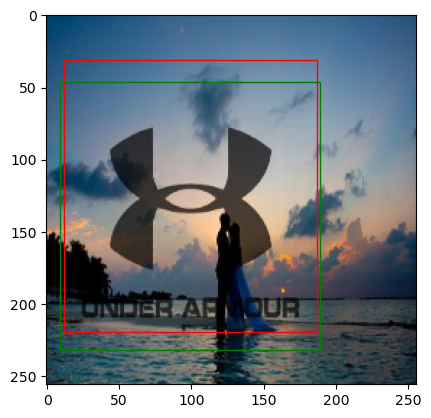

idx 3, model_bbox: (8, 214, 135, 311), target_bbox: (13, 219, 144, 246)


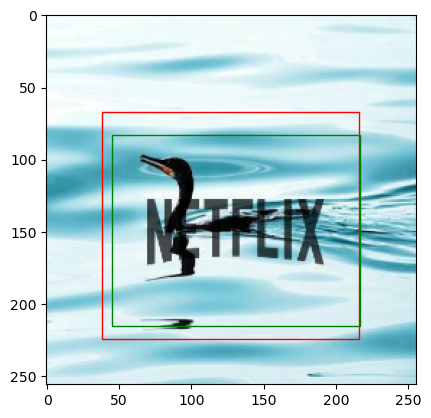

idx 6, model_bbox: (21, 198, 59, 199), target_bbox: (21, 196, 49, 188)


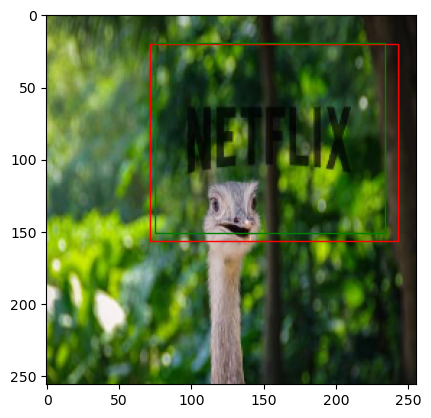

idx 9, model_bbox: (93, 218, 46, 185), target_bbox: (119, 211, 50, 196)


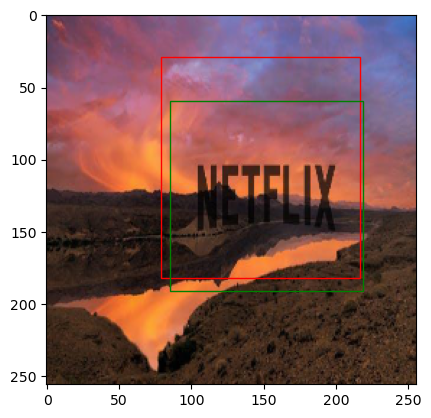

idx 12, model_bbox: (103, 227, 37, 170), target_bbox: (114, 216, 32, 172)


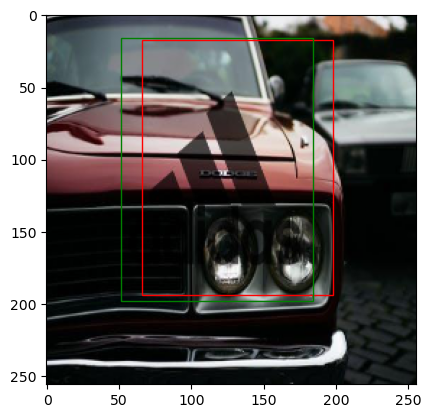

idx 15, model_bbox: (59, 230, 74, 225), target_bbox: (77, 213, 82, 226)


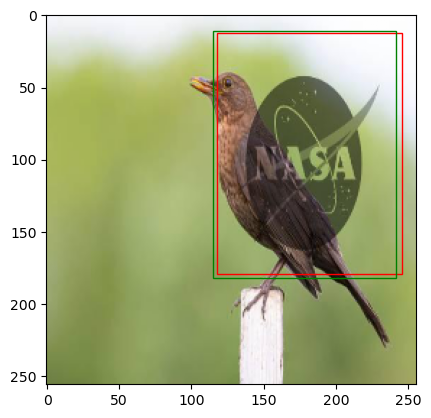

Accuracy: 0.81


In [23]:
# Evaluation loop
model.eval()
iou_threshold = 0.3
mae_threshold = 15
correct = 0
total = 0
plot_interval = 3

with torch.no_grad():
    for idx, (images, targets) in tqdm(enumerate(test_dataloader)):
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)

        # loop through all boxes in this batch, see if pred was correct
        model_bbox_list = yolo_to_bbox_list(outputs)
        target_bbox_list = yolo_to_bbox_list(targets)
        for img, model_bbox, target_bbox in zip(images, model_bbox_list, target_bbox_list):
            mae = calculate_mae(model_bbox, target_bbox)
            if mae <= mae_threshold:
                correct += 1
            total += 1

        # Display the first image from the batch with bounding boxes occasionally
        if idx % plot_interval == 0:
            y1_pred, x1_pred, y2_pred, x2_pred = model_bbox_list[0]
            y1_gt, x1_gt, y2_gt, x2_gt = target_bbox_list[0]
            print(f'idx {idx}, model_bbox: {model_bbox}, target_bbox: {target_bbox}')

            # display the watermarked image
            img = images[0].cpu().numpy().transpose(1, 2, 0)
            fig, ax = plt.subplots(1)
            ax.imshow(img)

            # build the rectangles for the bounding boxes
            pred_rect = patches.Rectangle(
                (y2_pred, y1_pred), x2_pred-y2_pred, x1_pred-y1_pred, linewidth=1, edgecolor='r', facecolor='none'
            )

            gt_rect = patches.Rectangle(
                (y2_gt, y1_gt), x2_gt-y2_gt, x1_gt-y1_gt, linewidth=1, edgecolor='g', facecolor='none'
            )
            ax.add_patch(pred_rect)
            ax.add_patch(gt_rect)
            plt.show()

accuracy = correct / total
print(f"Accuracy: {accuracy:.2f}")
